In [1]:
from pathlib import Path

import utils

import torch
import torch.nn as nn

import torchvision.models as models
import vision_transformer_dax as vits


##################################################################################
# python visualize_attention.py --image_path ../sample/covid.png --pretrained_weights vit_small --patch_size 8
model_type = "ViT-S-8"
checkpoint_file = "checkpoint/dax-checkpoint-vit-s-8-version-a.pth"
# checkpoint_file = "checkpoint/dino_deitsmall8_pretrain.pth"
##################################################################################

if model_type in ["ResNet18", "ResNet50"]:

    checkpoint = torch.load(Path(checkpoint_file), map_location="cpu", weights_only=False)
    teacher_checkpoint = checkpoint["teacher"]
    # Discard all weights and parameters belonging to DINOHead() ...
    teacher_dict = {k.replace("module.backbone.", ""): v for k, v in teacher_checkpoint.items() if k.startswith("module.backbone.")}

    assert model_type.lower() in models.__dict__.keys()
    resnet = models.__dict__[model_type.lower()](weights=None)
    embed_dim = resnet.fc.weight.shape[1]
    resnet.fc = nn.Identity() # Needed to successfully load checkpoint
    msg = resnet.load_state_dict(teacher_dict, strict=True)
    print(f"\nPretrained weights found at '{checkpoint_file}'\nand loaded with msg: {msg}")
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1]) # Discard the last FC layer (only needed for class predictions)

    model = resnet
    model = model.cuda()

elif model_type in ["ViT-T-16", "ViT-T-8"]:

    checkpoint = torch.load(Path(checkpoint_file), map_location="cpu", weights_only=False)
    teacher_checkpoint = checkpoint['teacher']
    # Discard all weights and parameters belonging to DINOHead() ...
    teacher_dict = {k.replace('backbone.', ''): v for k, v in teacher_checkpoint.items() if k.startswith('backbone.')}

    patch_size = int(model_type.split("-")[-1])
    vit_tiny = vits.vit_tiny(patch_size=patch_size)
    msg = vit_tiny.load_state_dict(teacher_dict, strict=True)
    print(f"\nPretrained weights found at '{checkpoint_file}'\nand loaded with msg: {msg}")
    
    model = vit_tiny
    model = model.cuda()

elif model_type in ["ViT-S-16", "ViT-S-8"]:

    checkpoint = torch.load(Path(checkpoint_file), map_location="cpu", weights_only=False)
    teacher_checkpoint = checkpoint['teacher']
    # Discard all weights and parameters belonging to DINOHead() ...
    teacher_dict = {k.replace('backbone.', ''): v for k, v in teacher_checkpoint.items() if k.startswith('backbone.')}

    patch_size = int(model_type.split("-")[-1])
    vit_small = vits.vit_small(patch_size=patch_size)
    msg = vit_small.load_state_dict(teacher_dict, strict=True)
    print(f"\nPretrained weights found at '{checkpoint_file}'\nand loaded with msg: {msg}")
    
    model = vit_small
    model = model.cuda()

print(f"\nPre-trained model has {utils.num_parameters(model)} million parameters!")


Pretrained weights found at 'checkpoint/dax-checkpoint-vit-s-8-version-a.pth'
and loaded with msg: <All keys matched successfully>

Pre-trained model has 21.67 million parameters!


In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ===== 1. 이미지 불러오기 =====
url = r"sample/covid.png"
img = Image.open(url ).convert("RGB")

# ===== 2. 전처리 =====
transform = T.Compose([
    T.Resize((480, 480)),       # ViT 입력 크기
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1] 범위
])

x = transform(img).unsqueeze(0).cuda()  # (1, 3, 224, 224)

# ===== 3. Attention hook 등록 =====
attn_maps = {}

def get_attn_maps(name):
    def hook(module, input, output):
        if isinstance(output, (tuple, list)) and len(output) > 1:
            attn_maps[name] = output[1].detach().cpu()  # (B, heads, N, N)
        elif hasattr(module, "last_attn"):
            attn_maps[name] = module.last_attn.detach().cpu()
    return hook

for i, blk in enumerate(model.blocks):
    blk.attn.register_forward_hook(get_attn_maps(f"attn_block_{i}"))

# ===== 4. Forward =====
_ = model(x)

# ===== 5. 어텐션 맵 시각화 =====
attn = attn_maps["attn_block_0"][0]  # (heads, N, N)
num_heads, N = attn.shape[0], attn.shape[1]

# # CLS → 패치 어텐션만 추출
# H = int((N - 1) ** 0.5)  # 패치 grid 크기 (14 for 224/16)
# cls_attn = attn[:, 0, 1:].reshape(num_heads, H, H)

# plt.figure(figsize=(15, 3))
# for h in range(num_heads):
#     plt.subplot(1, num_heads, h+1)
#     plt.imshow(cls_attn[h], cmap="inferno")
#     plt.title(f"Head {h}")
#     plt.axis("off")
# plt.show()

model.eval().cuda()

attn_maps = {}

def get_attn_maps(name):
    def hook(module, input, output):
        # output could be: tensor OR (out, attn) OR list/tuple containing attn
        attn = None
        if isinstance(output, (tuple, list)):
            # find a 4-D tensor (B, heads, N, N)
            for o in output:
                if isinstance(o, torch.Tensor) and o.dim() == 4:
                    attn = o
                    break
            # fallback
            if attn is None and len(output) > 1 and isinstance(output[1], torch.Tensor):
                attn = output[1]
        elif isinstance(output, torch.Tensor):
            # no attn returned; maybe module stored it as attribute (see 방법 B)
            if hasattr(module, "last_attn"):
                attn = module.last_attn

        if attn is None:
            return
        attn_maps[name] = attn.detach().cpu()
    return hook

# register hooks
for i, blk in enumerate(model.blocks):
    blk.attn.register_forward_hook(get_attn_maps(f"attn_block_{i}"))

# forward
_ = model(x)


KeyError: 'attn_block_12'

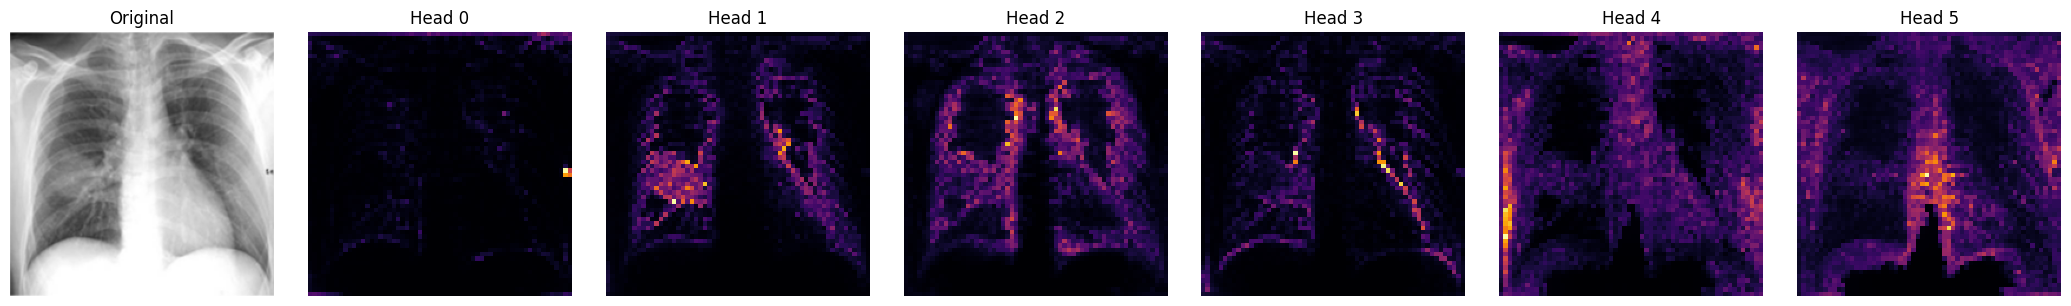

In [11]:

# visualize CLS -> patch attention for block 0
attn = attn_maps["attn_block_5"][0]  # shape (num_heads, N, N)
num_heads, N = attn.shape[0], attn.shape[1]
H = int((N - 1) ** 0.5)               # patch grid size (e.g. 14)
cls_attn = attn[:, 0, 1:].reshape(num_heads, H, H)

# ===== 원본 + Attention Map 비교 시각화 =====
fig = plt.figure(figsize=(3 + num_heads * 3, 3))  # 크기 조절

# 1. 원본 이미지
ax = plt.subplot(1, num_heads + 1, 1)
ax.imshow(img.resize((224, 224)))  # resize해서 비교
ax.set_title("Original")
ax.axis("off")

# 2. Attention 맵들
for h in range(num_heads):
    ax = plt.subplot(1, num_heads + 1, h + 2)
    ax.imshow(cls_attn[h], cmap="inferno")
    ax.set_title(f"Head {h}")
    ax.axis("off")

plt.tight_layout()
plt.show()

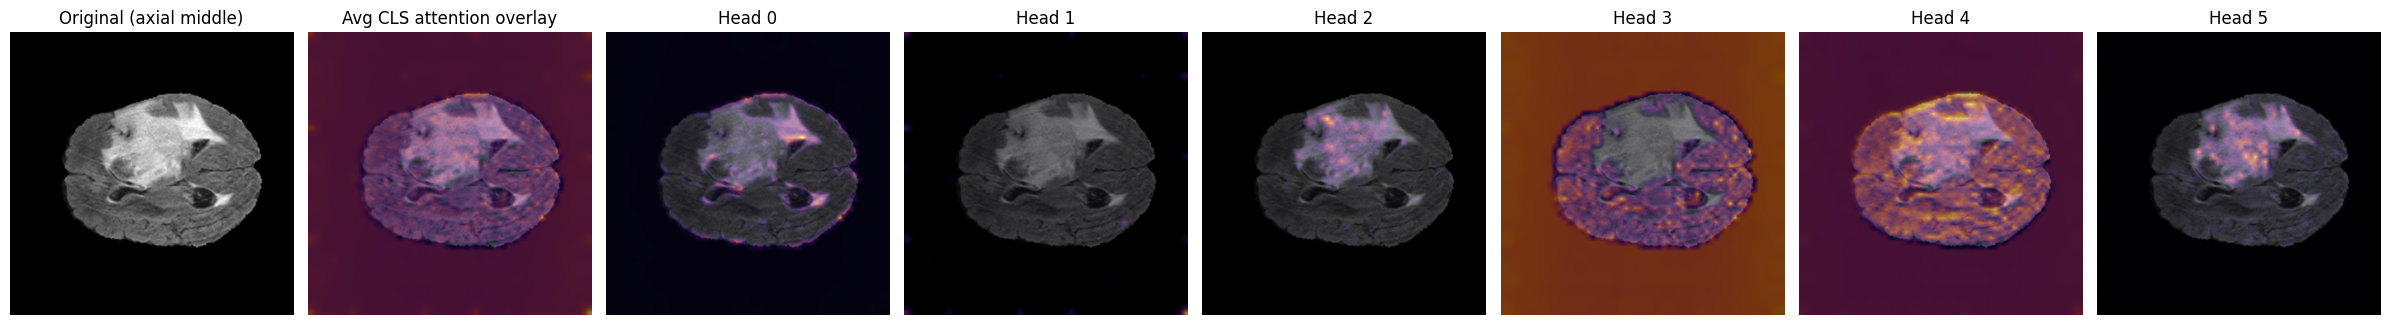

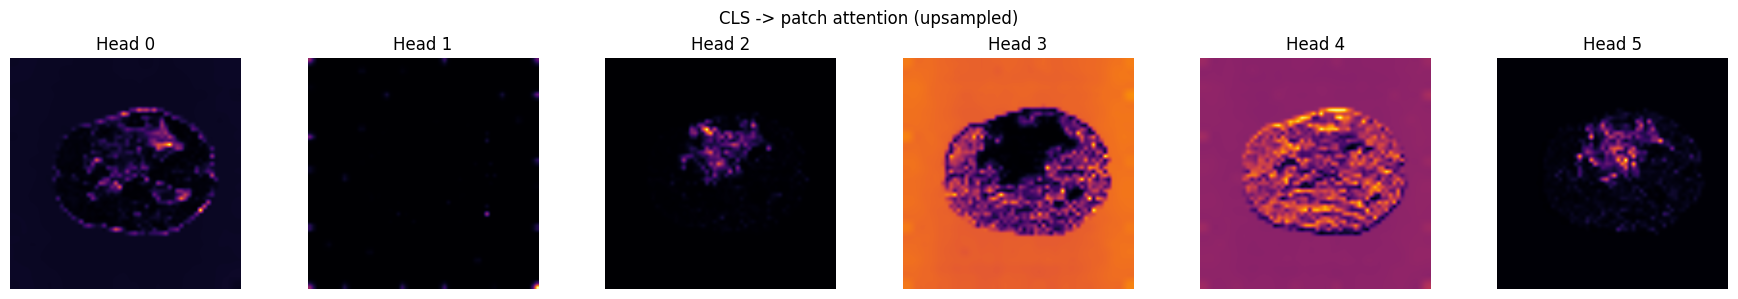

In [3]:
# save as run_brats_vit_attn.py
import os
import math
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# 사용자 설정
# ----------------------------
nii_path = "sample/brats/BraTS20_Training_001_flair.nii"  # 혹은 .nii.gz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 480           # ViT input size
patch_size = 16            # ViT patch size (기본 16)
visualize_block = 0        # 시각화할 블록 인덱스 (0..num_blocks-1)
use_average_last_block = False  # 마지막 블록들의 평균을 보고 싶으면 True

# ----------------------------
# 1) NIfTI 읽고 middle axial slice 선택
# ----------------------------
assert os.path.exists(nii_path), f"{nii_path} not found"

nii = nib.load(nii_path)
vol = nii.get_fdata()  # shape: (X, Y, Z) 보통 (H, W, D) or (rows, cols, slices)

# Ensure orientation: we assume vol is (H, W, D). If not, you may need to transpose.
if vol.ndim != 3:
    raise ValueError("Expected a 3D volume (H, W, D). Got shape: " + str(vol.shape))

h, w, d = vol.shape
mid_slice_idx = d // 2
slice2d = vol[:, :, mid_slice_idx]  # axial middle slice

# Normalize slice to 0..255 for visualization (min-max)
s = slice2d.copy()
s = s.astype(np.float32)
s_min, s_max = s.min(), s.max()
if s_max - s_min > 0:
    s = (s - s_min) / (s_max - s_min)
else:
    s = np.zeros_like(s)
s_uint8 = (s * 255).astype(np.uint8)

# Convert to PIL RGB by stacking (single-channel -> 3-channel)
pil_img = Image.fromarray(s_uint8).convert("L").resize((input_size, input_size))
# replicate to 3 channels because ViT expects 3 channels
pil_img_rgb = Image.merge("RGB", (pil_img, pil_img, pil_img))

# ----------------------------
# 2) 전처리 (same as earlier)
# ----------------------------
transform = T.Compose([
    T.ToTensor(),  # converts to [0,1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # to [-1, 1]
])
x = transform(pil_img_rgb).unsqueeze(0).to(device)  # shape (1,3,224,224)

# ----------------------------
# 3) Attention hook 준비 (robust)
# ----------------------------
attn_maps = {}

def get_attn_maps(name):
    def hook(module, input, output):
        # output might be: tensor OR (out, attn) OR other
        attn = None
        if isinstance(output, (tuple, list)):
            # find a 4-D tensor (B, heads, N, N)
            for o in output:
                if isinstance(o, torch.Tensor) and o.dim() == 4:
                    attn = o
                    break
            # fallback: second element
            if attn is None and len(output) > 1 and isinstance(output[1], torch.Tensor):
                attn = output[1]
        elif isinstance(output, torch.Tensor):
            # maybe module stored last_attn
            if hasattr(module, "last_attn"):
                attn = module.last_attn
        else:
            if hasattr(module, "last_attn"):
                attn = module.last_attn

        if attn is None:
            return
        # ensure detach to cpu
        attn_maps[name] = attn.detach().cpu()
    return hook

# register hooks on all blocks
for i, blk in enumerate(model.blocks):
    blk.attn.register_forward_hook(get_attn_maps(f"attn_block_{i}"))

model.to(device)
model.eval()

# ----------------------------
# 4) Forward
# ----------------------------
with torch.no_grad():
    _ = model(x)

# ----------------------------
# 5) 어텐션 추출 및 시각화 준비
# ----------------------------
# pick block(s)
if use_average_last_block:
    # average over last few blocks (example last 3)
    keys = sorted([k for k in attn_maps.keys()])
    last_keys = keys[-3:]
    # attn shape: (B, heads, N, N)
    atts = [attn_maps[k][0] for k in last_keys if k in attn_maps]  # list of (heads, N, N)
    if len(atts) == 0:
        raise RuntimeError("No attention maps captured.")
    # stack and mean across blocks
    attn = torch.stack(atts, dim=0).mean(dim=0)  # (heads, N, N)
else:
    name = f"attn_block_{visualize_block}"
    if name not in attn_maps:
        # fallback to last available
        if len(attn_maps) == 0:
            raise RuntimeError("No attention maps captured. Check hooks.")
        name = sorted(attn_maps.keys())[-1]
    attn = attn_maps[name][0]  # (heads, N, N)

# attn -> numpy
attn = attn.numpy()
num_heads, N, _ = attn.shape
# patch grid size
num_patches = N - 1  # excluding CLS
grid_size = int(math.sqrt(num_patches))
assert grid_size * grid_size == num_patches, "Unexpected patch layout. N-1 must be square."

# CLS -> patches attention
cls_attn = attn[:, 0, 1:]  # (heads, num_patches)
# reshape per head to (grid_size, grid_size)
cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)  # (heads, H, W)

# upsample each head map to input_size for overlay
cls_attn_t = torch.from_numpy(cls_attn_maps).unsqueeze(1)  # (heads,1,H,W)
upsampled = F.interpolate(cls_attn_t, size=(input_size, input_size), mode='bilinear', align_corners=False)  # (heads,1,224,224)
upsampled = upsampled.squeeze(1).numpy()  # (heads, 224, 224)

# normalize each head map 0..1
upsampled_norm = []
for h in range(num_heads):
    m = upsampled[h]
    m_min, m_max = m.min(), m.max()
    if m_max - m_min > 0:
        mn = (m - m_min) / (m_max - m_min)
    else:
        mn = np.zeros_like(m)
    upsampled_norm.append(mn)
upsampled_norm = np.stack(upsampled_norm, axis=0)  # (heads, H, W)

# ----------------------------
# 6) 시각화: 원본 슬라이스 + 각 head 맵 + overlay
# ----------------------------
fig_cols = 2 + num_heads  # original + overlay + per-head
fig = plt.figure(figsize=(3*fig_cols, 4))

# Original
ax = plt.subplot(1, fig_cols, 1)
ax.imshow(pil_img, cmap='gray')
ax.set_title("Original (axial middle)")
ax.axis("off")

# Overlay average of heads (or choose one)
avg_map = upsampled_norm.mean(axis=0)
ax = plt.subplot(1, fig_cols, 2)
ax.imshow(pil_img, cmap='gray')
ax.imshow(avg_map, cmap='inferno', alpha=0.5)  # overlay
ax.set_title("Avg CLS attention overlay")
ax.axis("off")

# Per-head maps and overlays
for h in range(num_heads):
    ax = plt.subplot(1, fig_cols, 3 + h)
    ax.imshow(pil_img, cmap='gray')
    ax.imshow(upsampled_norm[h], cmap='inferno', alpha=0.5)
    ax.set_title(f"Head {h}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# ----------------------------
# 추가: 원하면 attention map만 큰 격자로 보여주기
# ----------------------------
# e.g., show all heads as grid of heatmaps
cols = min(8, num_heads)
rows = math.ceil(num_heads / cols)
plt.figure(figsize=(3*cols, 3*rows))
for h in range(num_heads):
    plt.subplot(rows, cols, h+1)
    plt.imshow(upsampled_norm[h], cmap='inferno')
    plt.title(f"Head {h}")
    plt.axis("off")
plt.suptitle("CLS -> patch attention (upsampled)")
plt.tight_layout()
plt.show()


Found NIfTI files: ['BraTS20_Training_001_flair.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t2.nii']


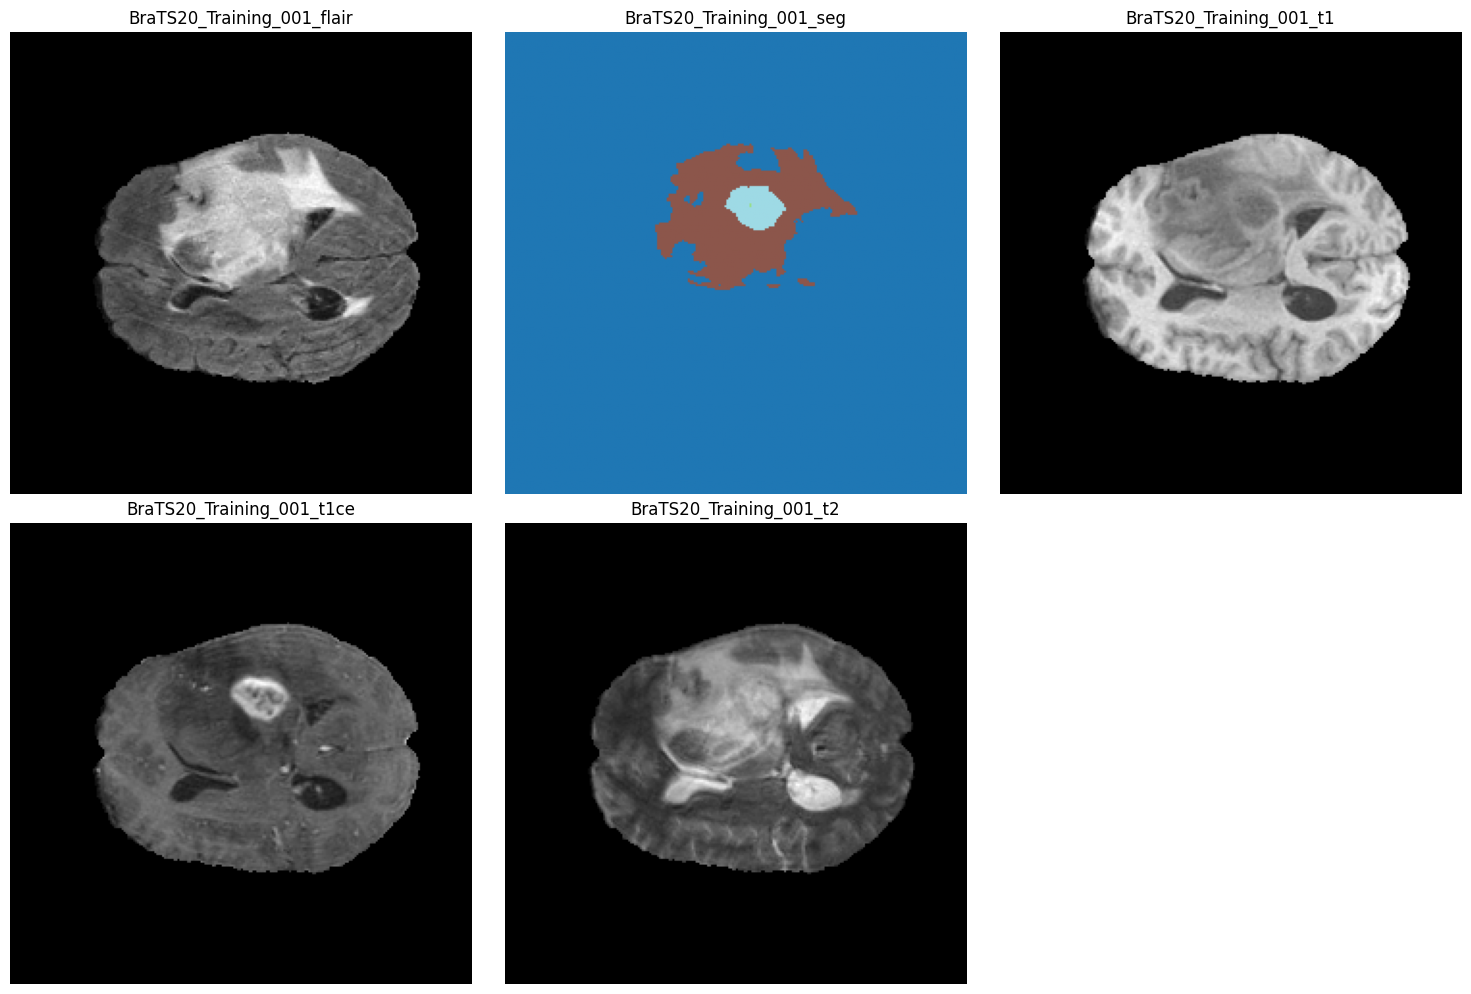

In [4]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 설정
# -------------------------
data_dir = "sample/brats/"   # nii 파일이 있는 디렉토리
save_fig = False # True로 하면 PNG 저장

# -------------------------
# 1. nii 파일 목록 가져오기
# -------------------------
nii_files = [f for f in os.listdir(data_dir) if f.endswith(".nii")]
nii_files.sort()  # 보기 좋게 정렬

print("Found NIfTI files:", nii_files)

# -------------------------
# 2. 각 파일에서 중간 슬라이스 추출
# -------------------------
slices = []
titles = []

for f in nii_files:
    path = os.path.join(data_dir, f)
    nii = nib.load(path)
    vol = nii.get_fdata()

    if vol.ndim != 3:
        print(f"⚠️ Skip {f}, shape={vol.shape}")
        continue

    # 중간 axial slice
    mid_idx = vol.shape[2] // 2
    slice2d = vol[:, :, mid_idx].astype(np.float32)

    # intensity normalize (0~1)
    s_min, s_max = slice2d.min(), slice2d.max()
    if s_max > s_min:
        slice2d = (slice2d - s_min) / (s_max - s_min)
    else:
        slice2d = np.zeros_like(slice2d)

    slices.append(slice2d)
    titles.append(f.replace(".nii", ""))

# -------------------------
# 3. 시각화
# -------------------------
n = len(slices)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5*cols, 5*rows))
for i, (slc, title) in enumerate(zip(slices, titles)):
    ax = plt.subplot(rows, cols, i+1)
    cmap = "gray"
    if "seg" in title.lower():
        cmap = "tab20"  # segmentation은 컬러로
    ax.imshow(slc, cmap=cmap)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()

if save_fig:
    plt.savefig("brats_case001_modalities.png", dpi=150)
plt.show()


In [5]:
# run_all_modalities_vit_attn.py
import os
import math
import nibabel as nib
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# 사용자 설정 (필요시 변경)
# ----------------------------
data_dir = "sample/brats"   # .nii들이 들어있는 디렉토리
output_dir = "outputs"      # 결과 저장 폴더
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 480            # ViT input size (사용하던 값 유지)
patch_size = 16             # patch size (정보용)
visualize_block = 0         # 시각화할 블록 인덱스 (기본 0)
use_average_last_block = False  # 마지막 블록 평균 사용 여부
save_png = True

os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# 모델 준비: 반드시 외부에서 model 변수를 로드해두세요.
# 예: model = timm.create_model('vit_base_patch16_224', pretrained=True)
# 그리고 model.blocks[i].attn 에 접근 가능해야 합니다.
# ----------------------------
# assert 'model' in globals() 혹은 아래에 모델 로드 코드를 넣어주세요.
try:
    model
except NameError:
    raise RuntimeError("`model`이 현재 네임스페이스에 없습니다. 모델을 로드한 뒤 스크립트를 실행하세요.")

model.to(device)
model.eval()

# ----------------------------
# 전처리 설정 (원래 코드와 동일)
# ----------------------------
transform = T.Compose([
    T.ToTensor(),  # converts to [0,1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # to [-1,1]
])

# ----------------------------
# Hook 준비 (기존 robust 버전)
# ----------------------------
def make_attn_hook(attn_maps, name):
    def hook(module, input, output):
        attn = None
        if isinstance(output, (tuple, list)):
            for o in output:
                if isinstance(o, torch.Tensor) and o.dim() == 4:
                    attn = o
                    break
            if attn is None and len(output) > 1 and isinstance(output[1], torch.Tensor):
                attn = output[1]
        elif isinstance(output, torch.Tensor):
            if hasattr(module, "last_attn"):
                attn = module.last_attn
        else:
            if hasattr(module, "last_attn"):
                attn = module.last_attn

        if attn is None:
            return
        attn_maps[name] = attn.detach().cpu()
    return hook

# register hooks once
attn_maps_global = {}
for i, blk in enumerate(model.blocks):
    blk.attn.register_forward_hook(make_attn_hook(attn_maps_global, f"attn_block_{i}"))

# ----------------------------
# 파일 순회 및 처리
# ----------------------------
nii_files = [f for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
nii_files.sort()
print("Found NIfTI files:", nii_files)

for fname in nii_files:
    path = os.path.join(data_dir, fname)
    print(f"\nProcessing: {fname}")
    try:
        nii = nib.load(path)
        vol = nii.get_fdata()
        if vol.ndim != 3:
            print(f"  Skipping {fname}: expected 3D volume, got shape {vol.shape}")
            continue

        # 중간 axial 슬라이스
        mid_idx = vol.shape[2] // 2
        slice2d = vol[:, :, mid_idx].astype(np.float32)

        # 정규화 (visualization 용)
        s_min, s_max = slice2d.min(), slice2d.max()
        if s_max > s_min:
            norm = (slice2d - s_min) / (s_max - s_min)
        else:
            norm = np.zeros_like(slice2d)
        s_uint8 = (norm * 255).astype(np.uint8)

        # PIL 이미지(그레이) 생성 및 리사이즈
        pil_img = Image.fromarray(s_uint8).convert("L").resize((input_size, input_size))
        pil_img_rgb = Image.merge("RGB", (pil_img, pil_img, pil_img))

        # transform -> tensor
        x = transform(pil_img_rgb).unsqueeze(0).to(device)  # (1,3,H,W)

        # clear attn_map container BEFORE forward for each file
        attn_maps_global.clear()

        # forward
        with torch.no_grad():
            _ = model(x)

        # select attention
        if use_average_last_block:
            keys = sorted([k for k in attn_maps_global.keys()])
            last_keys = keys[-3:]
            atts = [attn_maps_global[k][0] for k in last_keys if k in attn_maps_global]
            if len(atts) == 0:
                print("  No attention captured for", fname)
                continue
            attn = torch.stack(atts, dim=0).mean(dim=0)  # (heads, N, N)
        else:
            name = f"attn_block_{visualize_block}"
            if name not in attn_maps_global:
                if len(attn_maps_global) == 0:
                    print("  No attention captured for", fname)
                    continue
                name = sorted(attn_maps_global.keys())[-1]
            attn = attn_maps_global[name][0]  # (heads, N, N)

        attn = attn.numpy()
        num_heads, N, _ = attn.shape
        num_patches = N - 1
        grid_size = int(math.sqrt(num_patches))
        if grid_size * grid_size != num_patches:
            print("  Unexpected patch layout for", fname, "- skipping")
            continue

        # CLS -> patches
        cls_attn = attn[:, 0, 1:]  # (heads, num_patches)
        cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)

        # upsample to input_size
        cls_attn_t = torch.from_numpy(cls_attn_maps).unsqueeze(1)  # (heads,1,gs,gs)
        upsampled = F.interpolate(cls_attn_t, size=(input_size, input_size), mode='bilinear', align_corners=False)
        upsampled = upsampled.squeeze(1).numpy()  # (heads, H, W)

        # normalize per-head
        upsampled_norm = []
        for h in range(num_heads):
            m = upsampled[h]
            m_min, m_max = m.min(), m.max()
            if m_max > m_min:
                mn = (m - m_min) / (m_max - m_min)
            else:
                mn = np.zeros_like(m)
            upsampled_norm.append(mn)
        upsampled_norm = np.stack(upsampled_norm, axis=0)

        # overlay 평균 map
        avg_map = upsampled_norm.mean(axis=0)

        # ----------------------------
        # 시각화 (원본 / avg overlay / per-head overlay)
        # ----------------------------
        fig_cols = 2 + min(num_heads, 8)  # 화면 과도하지 않게 보여주기 (최대 8개 head)
        fig = plt.figure(figsize=(3*fig_cols, 4))

        # Original
        ax = plt.subplot(1, fig_cols, 1)
        ax.imshow(pil_img, cmap='gray')
        ax.set_title(f"{fname} (mid axial)")
        ax.axis("off")

        # Overlay average
        ax = plt.subplot(1, fig_cols, 2)
        ax.imshow(pil_img, cmap='gray')
        ax.imshow(avg_map, cmap='inferno', alpha=0.5)
        ax.set_title("Avg CLS attention")
        ax.axis("off")

        # Per-head (최대 8개)
        heads_to_show = min(num_heads, 8)
        for h in range(heads_to_show):
            ax = plt.subplot(1, fig_cols, 3 + h)
            ax.imshow(pil_img, cmap='gray')
            ax.imshow(upsampled_norm[h], cmap='inferno', alpha=0.5)
            ax.set_title(f"Head {h}")
            ax.axis("off")

        plt.tight_layout()

        out_png = os.path.join(output_dir, f"{os.path.splitext(fname)[0]}_attn.png")
        if save_png:
            plt.savefig(out_png, dpi=150, bbox_inches='tight')
            print("  Saved:", out_png)
        plt.close(fig)

        # ----------------------------
        # 추가: segmentation 파일이면 mask overlay도 저장 (컬러 마스크)
        # ----------------------------
        if "seg" in fname.lower():
            # seg에는 레이블 값들이 있으므로 컬러 렌더링
            seg_mask = slice2d  # original seg slice values
            # normalize seg labels to small int range for visualization
            unique_vals = np.unique(seg_mask)
            # make rgb mask
            mask_rgb = np.zeros((seg_mask.shape[0], seg_mask.shape[1], 3), dtype=np.uint8)
            # simple colormap: skip 0
            colors = [
                (0,0,0), (255,0,0), (0,255,0), (0,0,255),
                (255,255,0),(255,0,255),(0,255,255),(128,128,128)
            ]
            for i, v in enumerate(unique_vals):
                if v == 0:
                    continue
                c = colors[(i) % len(colors)]
                mask_rgb[seg_mask == v] = c
            # convert and resize
            mask_pil = Image.fromarray(mask_rgb).resize((input_size, input_size))
            # save mask
            mask_out = os.path.join(output_dir, f"{os.path.splitext(fname)[0]}_mask.png")
            mask_pil.save(mask_out)
            print("  Saved segmentation mask:", mask_out)

    except Exception as e:
        print("  Error processing", fname, "-", str(e))
        continue

print("\nAll done. Outputs saved in:", output_dir)


Found NIfTI files: ['BraTS20_Training_001_flair.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t2.nii']

Processing: BraTS20_Training_001_flair.nii


KeyboardInterrupt: 

In [ ]:
# run_all_modalities_vit_attn.py
import os
import math
import nibabel as nib
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# 사용자 설정
# ----------------------------
data_dir = "sample/brats"   # .nii 파일 경로
output_dir = "outputs"      # 결과 저장 폴더
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 480            # ViT 입력 크기
patch_size = 16             # ViT patch size
visualize_block = 0         # 시각화할 블록 인덱스
use_average_last_block = False
save_png = True

os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# 모델 로드 확인
# ----------------------------
try:
    model
except NameError:
    raise RuntimeError("`model` 변수가 없습니다. 모델을 로드 후 실행하세요.")

model.to(device)
model.eval()

# ----------------------------
# 전처리
# ----------------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ----------------------------
# Attention hook 준비
# ----------------------------
def make_attn_hook(attn_maps, name):
    def hook(module, input, output):
        attn = None
        if isinstance(output, (tuple, list)):
            for o in output:
                if isinstance(o, torch.Tensor) and o.dim() == 4:
                    attn = o
                    break
            if attn is None and len(output) > 1 and isinstance(output[1], torch.Tensor):
                attn = output[1]
        elif isinstance(output, torch.Tensor):
            if hasattr(module, "last_attn"):
                attn = module.last_attn
        else:
            if hasattr(module, "last_attn"):
                attn = module.last_attn

        if attn is None:
            return
        attn_maps[name] = attn.detach().cpu()
    return hook

# hooks 등록
attn_maps_global = {}
for i, blk in enumerate(model.blocks):
    blk.attn.register_forward_hook(make_attn_hook(attn_maps_global, f"attn_block_{i}"))

# ----------------------------
# NIfTI 파일 순회
# ----------------------------
nii_files = [f for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
nii_files.sort()
print("Found NIfTI files:", nii_files)

for fname in nii_files:
    path = os.path.join(data_dir, fname)
    print(f"\nProcessing: {fname}")
    try:
        nii = nib.load(path)
        vol = nii.get_fdata()
        if vol.ndim != 3:
            print(f"  Skipping {fname}: expected 3D volume, got shape {vol.shape}")
            continue

        # 중간 axial slice
        mid_idx = vol.shape[2] // 2
        slice2d = vol[:, :, mid_idx].astype(np.float32)

        # 정규화
        s_min, s_max = slice2d.min(), slice2d.max()
        norm = (slice2d - s_min) / (s_max - s_min) if s_max > s_min else np.zeros_like(slice2d)
        s_uint8 = (norm * 255).astype(np.uint8)

        # PIL 이미지
        pil_img = Image.fromarray(s_uint8).convert("L").resize((input_size, input_size))
        pil_img_rgb = Image.merge("RGB", (pil_img, pil_img, pil_img))

        # Tensor 변환
        x = transform(pil_img_rgb).unsqueeze(0).to(device)

        # clear attn_maps
        attn_maps_global.clear()

        # forward
        with torch.no_grad():
            _ = model(x)

        # Attention 선택
        if use_average_last_block:
            keys = sorted(attn_maps_global.keys())
            last_keys = keys[-3:]
            atts = [attn_maps_global[k][0] for k in last_keys if k in attn_maps_global]
            if len(atts) == 0:
                print("  No attention captured for", fname)
                continue
            attn = torch.stack(atts, dim=0).mean(dim=0)
        else:
            name = f"attn_block_{visualize_block}"
            if name not in attn_maps_global:
                if len(attn_maps_global) == 0:
                    print("  No attention captured for", fname)
                    continue
                name = sorted(attn_maps_global.keys())[-1]
            attn = attn_maps_global[name][0]

        attn = attn.numpy()
        num_heads, N, _ = attn.shape
        num_patches = N - 1
        grid_size = int(math.sqrt(num_patches))
        if grid_size * grid_size != num_patches:
            print("  Unexpected patch layout for", fname, "- skipping")
            continue

        # CLS -> patch attention
        cls_attn = attn[:, 0, 1:]
        cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)

        # 업샘플
        cls_attn_t = torch.from_numpy(cls_attn_maps).unsqueeze(1)
        upsampled = F.interpolate(cls_attn_t, size=(input_size, input_size), mode='bilinear', align_corners=False)
        upsampled = upsampled.squeeze(1).numpy()

        # normalize per-head
        upsampled_norm = []
        for h in range(num_heads):
            m = upsampled[h]
            m_min, m_max = m.min(), m.max()
            mn = (m - m_min) / (m_max - m_min) if m_max > m_min else np.zeros_like(m)
            upsampled_norm.append(mn)
        upsampled_norm = np.stack(upsampled_norm, axis=0)

        avg_map = upsampled_norm.mean(axis=0)

        # ----------------------------
        # 시각화 3행: 원본/overlay, head heatmap, seg mask
        # ----------------------------
        rows = 3 if "seg" in fname.lower() else 2
        cols = 2 + min(num_heads, 8)
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

        # 1행: 원본 + avg overlay + head overlay
        axes[0,0].imshow(pil_img, cmap='gray')
        axes[0,0].set_title(f"{fname}\n(mid axial)")
        axes[0,0].axis("off")

        axes[0,1].imshow(pil_img, cmap='gray')
        axes[0,1].imshow(avg_map, cmap='inferno', alpha=0.5)
        axes[0,1].set_title("Avg CLS attention")
        axes[0,1].axis("off")

        heads_to_show = min(num_heads, cols-2)
        for h in range(heads_to_show):
            axes[0, 2+h].imshow(pil_img, cmap='gray')
            axes[0, 2+h].imshow(upsampled_norm[h], cmap='inferno', alpha=0.5)
            axes[0, 2+h].set_title(f"Head {h}")
            axes[0, 2+h].axis("off")

        # 2행: head heatmaps만
        for c in range(cols):
            if c < 2:
                axes[1, c].axis("off")
                continue
            h = c - 2
            if h < num_heads:
                axes[1, c].imshow(upsampled_norm[h], cmap='inferno')
                axes[1, c].set_title(f"Head {h} heatmap")
            axes[1, c].axis("off")

        # 3행: segmentation mask
        if "seg" in fname.lower():
            for c in range(cols):
                axes[2, c].axis("off")
            seg_mask = slice2d.astype(int)
            unique_vals = np.unique(seg_mask)
            mask_rgb = np.zeros((seg_mask.shape[0], seg_mask.shape[1], 3), dtype=np.uint8)
            colors = [
                (0,0,0), (255,0,0), (0,255,0), (0,0,255),
                (255,255,0),(255,0,255),(0,255,255),(128,128,128)
            ]
            for i, v in enumerate(unique_vals):
                if v == 0: continue
                mask_rgb[seg_mask == v] = colors[i % len(colors)]
            mask_pil = Image.fromarray(mask_rgb).resize((input_size, input_size))
            axes[2,0].imshow(mask_pil)
            axes[2,0].set_title("Segmentation mask")

        plt.tight_layout()
        out_png = os.path.join(output_dir, f"{os.path.splitext(fname)[0]}_attn.png")
        if save_png:
            plt.savefig(out_png, dpi=150, bbox_inches='tight')
            print("  Saved:", out_png)
        plt.close(fig)

    except Exception as e:
        print("  Error processing", fname, "-", str(e))
        continue

print("\nAll done. Outputs saved in:", output_dir)


Found NIfTI files: ['BraTS20_Training_001_flair.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t2.nii']

Processing: BraTS20_Training_001_flair.nii
  Saved: outputs/BraTS20_Training_001_flair_attn.png

Processing: BraTS20_Training_001_seg.nii
  Saved: outputs/BraTS20_Training_001_seg_attn.png

Processing: BraTS20_Training_001_t1.nii
  Saved: outputs/BraTS20_Training_001_t1_attn.png

Processing: BraTS20_Training_001_t1ce.nii
  Saved: outputs/BraTS20_Training_001_t1ce_attn.png

Processing: BraTS20_Training_001_t2.nii
  Saved: outputs/BraTS20_Training_001_t2_attn.png

All done. Outputs saved in: outputs


In [14]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

# NIfTI 파일 리스트
nii_files = [
    "sample/brats/BraTS20_Training_001_flair.nii",
    "sample/brats/BraTS20_Training_001_seg.nii",
    "sample/brats/BraTS20_Training_001_t1.nii",
    "sample/brats/BraTS20_Training_001_t1ce.nii",
    "sample/brats/BraTS20_Training_001_t2.nii"
]

output_dir = "sample/brats/png_slices"
os.makedirs(output_dir, exist_ok=True)

for nii_path in nii_files:
    # 파일 읽기
    img = sitk.ReadImage(nii_path)
    img_array = sitk.GetArrayFromImage(img)  # (D, H, W)

    # 중간 슬라이스 선택
    mid_slice_idx = img_array.shape[0] // 2
    mid_slice = img_array[mid_slice_idx]

    # 시각화 + 저장
    plt.imshow(mid_slice, cmap='gray')
    plt.axis('off')

    base_name = os.path.basename(nii_path).replace(".nii", "_mid.png")
    out_path = os.path.join(output_dir, base_name)
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Saved {out_path}")


Saved sample/brats/png_slices/BraTS20_Training_001_flair_mid.png
Saved sample/brats/png_slices/BraTS20_Training_001_seg_mid.png
Saved sample/brats/png_slices/BraTS20_Training_001_t1_mid.png
Saved sample/brats/png_slices/BraTS20_Training_001_t1ce_mid.png
Saved sample/brats/png_slices/BraTS20_Training_001_t2_mid.png
